<a href="https://colab.research.google.com/github/easthometown/HMP_Dataset/blob/master/Copy_of_Deep_Learning_with_PyTorch_Object_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro Task, Object Localization 

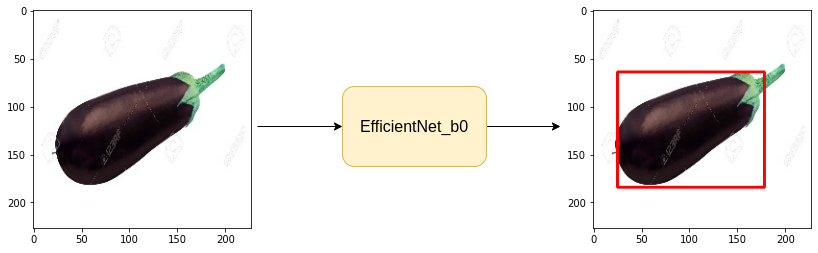

In [1]:
# install libraries/packages/modules 

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-1e4fu102
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-1e4fu102
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

fatal: destination path 'object-localization-dataset' already exists and is not an empty directory.


In [3]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [5]:
CSV_FILE='/content/object-localization-dataset/train.csv'
DATA_DIR='/content/object-localization-dataset'

DEVICE='cuda'

BATCH_SIZE=16
IMG_SIZE=140

LR=0.001
EPOCHS=40
#MODEL_NAME='efficientnet_b0'
MODEL_NAME='resnet50'
NUM_COR=4

In [6]:
df=pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

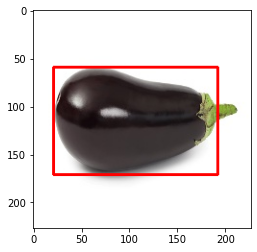

In [7]:
row = df.iloc[184]
import os
path=os.path.join(DATA_DIR,row.img_path)
img = cv2.imread(path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(img,pt1,pt2,(255,0,0),2)
plt.imshow(bnd_box_img)

In [8]:
train_df,valid_df=train_test_split(df,test_size=0.20,random_state=42)

# Augmentations

In [9]:
import albumentations as A

In [10]:
train_augs = A.Compose([
                        A.Resize(IMG_SIZE,IMG_SIZE),
                        A.HorizontalFlip(p=0.5),
                        A.VerticalFlip(p=0.5),
                        A.Rotate()
],bbox_params=A.BboxParams(format='pascal_voc',label_fields=['class_labels']))

valid_augs = A.Compose([
                        A.Resize(IMG_SIZE,IMG_SIZE),
                        
],bbox_params=A.BboxParams(format='pascal_voc',label_fields=['class_labels']))

# Create Custom Dataset

In [15]:
class ObjLocDataset(torch.utils.data.Dataset):
  def __init__(self,df,augmentations = None):
    self.df=df
    self.augmentations=augmentations
  
  def __len__(self):
    return len(self.df)
  
  def __getitem__(self,idx):
    row = self.df.iloc[idx]

    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax

    bbox=[[xmin,ymin,xmax,ymax]]

    #img_path = DATA_DIR + row.img_path
    img_path=os.path.join(DATA_DIR,row.img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data = self.augmentations(image = img,bboxes=bbox,class_labels=[None])
      img = data['image']
      bbox = data['bboxes'][0]
    
    img = torch.from_numpy(img).permute(2,0,1)/255.0 #(h,w,c)->(c,h,w)
    bbox = torch.Tensor(bbox)
    return img,bbox

In [16]:
trainset = ObjLocDataset(train_df,train_augs)
validset = ObjLocDataset(valid_df,valid_augs)

In [17]:
print(f'Total examples in the trainset : {len(trainset)}')
print(f'Total examples in the validset : {len(validset)}')

Total examples in the trainset : 148
Total examples in the validset : 38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


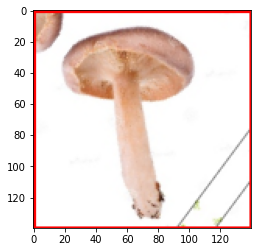

In [18]:
img, bbox = trainset[120]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [19]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
validloader = torch.utils.data.DataLoader(validset,batch_size=BATCH_SIZE,shuffle=False)

In [20]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [21]:
for images,bboxes in trainloader:
  break;


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [22]:
from torch import nn 
import timm

In [23]:
class ObjLocModel(nn.Module):
  def __init__(self):
    super(ObjLocModel, self).__init__()
    self.backbone = timm.create_model(MODEL_NAME,pretrained=True,num_classes=4)
  
  def forward(self,images,gt_bboxes=None):
    bboxes = self.backbone(images)
    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes,gt_bboxes)
      return bboxes,loss
    
    return bboxes

In [24]:
model = ObjLocModel()
model.to(DEVICE);

In [25]:
random_img = torch.rand(1,3,140,140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [26]:
def train_fn(model,dataloader,optimizer):
  total_loss=0.0
  model.train() #Dropout ON

  for data in tqdm(dataloader):
    images, gt_bboxes = data
    images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

    bboxes, loss = model(images, gt_bboxes)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(dataloader)

In [27]:
def eval_fn(model,dataloader):
  total_loss=0.0
  model.eval() #Dropout OFF

  with torch.no_grad():

    for data in tqdm(dataloader):
      images, gt_bboxes = data
      images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

      bboxes, loss = model(images, gt_bboxes)
      total_loss += loss.item()

    return total_loss/len(dataloader)

#Training Loop

In [28]:
optimizer = torch.optim.Adam(model.parameters(),lr=LR)

In [29]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(model,trainloader,optimizer)
  valid_loss = eval_fn(model, validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print("WEIGHTS=ARE=SAVED")
    best_valid_loss=valid_loss
  print(f'Epoch : {i +1} train loss : {train_loss} valid loss : {valid_loss}')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS=ARE=SAVED
Epoch : 1 train loss : 7640.448046875 valid loss : 6888.984375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS=ARE=SAVED
Epoch : 2 train loss : 7040.5119140625 valid loss : 5516.509114583333


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS=ARE=SAVED
Epoch : 3 train loss : 6010.8484375 valid loss : 3494.1653645833335


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS=ARE=SAVED
Epoch : 4 train loss : 4696.646630859375 valid loss : 1818.7095947265625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS=ARE=SAVED
Epoch : 5 train loss : 3171.7640625 valid loss : 1317.3255208333333


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS=ARE=SAVED
Epoch : 6 train loss : 1576.0856994628907 valid loss : 478.8009338378906


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS=ARE=SAVED
Epoch : 7 train loss : 567.239582824707 valid loss : 417.8381856282552


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS=ARE=SAVED
Epoch : 8 train loss : 252.5517791748047 valid loss : 303.9685872395833


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS=ARE=SAVED
Epoch : 9 train loss : 217.98413696289063 valid loss : 268.0865834554036


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS=ARE=SAVED
Epoch : 10 train loss : 213.35964813232422 valid loss : 262.41436767578125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 11 train loss : 197.47884368896484 valid loss : 265.9611511230469


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS=ARE=SAVED
Epoch : 12 train loss : 226.46416778564452 valid loss : 255.6450398763021


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 13 train loss : 198.05248565673827 valid loss : 265.7857360839844


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS=ARE=SAVED
Epoch : 14 train loss : 171.32518005371094 valid loss : 225.17207845052084


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS=ARE=SAVED
Epoch : 15 train loss : 188.60944671630858 valid loss : 223.4710489908854


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 16 train loss : 187.1749740600586 valid loss : 235.55535888671875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 17 train loss : 174.30465698242188 valid loss : 229.3314412434896


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 18 train loss : 164.57632598876953 valid loss : 233.70967610677084


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS=ARE=SAVED
Epoch : 19 train loss : 155.0577819824219 valid loss : 196.93346659342447


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS=ARE=SAVED
Epoch : 20 train loss : 140.65242919921874 valid loss : 192.12356567382812


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS=ARE=SAVED
Epoch : 21 train loss : 138.7209274291992 valid loss : 155.67923482259116


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS=ARE=SAVED
Epoch : 22 train loss : 118.58590698242188 valid loss : 154.6879679361979


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 23 train loss : 130.39566040039062 valid loss : 160.8130086263021


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS=ARE=SAVED
Epoch : 24 train loss : 113.25179290771484 valid loss : 144.5604451497396


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 25 train loss : 115.79500808715821 valid loss : 155.66355641682944


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS=ARE=SAVED
Epoch : 26 train loss : 106.11757049560546 valid loss : 136.52703603108725


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 27 train loss : 104.90728454589843 valid loss : 153.02584075927734


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 28 train loss : 92.6044937133789 valid loss : 148.1306610107422


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS=ARE=SAVED
Epoch : 29 train loss : 98.59321613311768 valid loss : 118.82661692301433


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 30 train loss : 98.45208473205567 valid loss : 129.33870951334634


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 31 train loss : 94.35976638793946 valid loss : 134.2944768269857


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 32 train loss : 97.69617919921875 valid loss : 122.6189473470052


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 33 train loss : 101.85176963806153 valid loss : 124.99430338541667


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS=ARE=SAVED
Epoch : 34 train loss : 101.87702217102051 valid loss : 118.30702209472656


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 35 train loss : 81.12536354064942 valid loss : 124.84170023600261


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS=ARE=SAVED
Epoch : 36 train loss : 84.28635673522949 valid loss : 115.77892812093098


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS=ARE=SAVED
Epoch : 37 train loss : 94.91124877929687 valid loss : 115.67451985677083


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 38 train loss : 85.51404418945313 valid loss : 202.4029083251953


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 39 train loss : 74.31927337646485 valid loss : 119.06648763020833


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS=ARE=SAVED
Epoch : 40 train loss : 101.57316093444824 valid loss : 99.67530059814453


#Inference

In [30]:
import utils

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


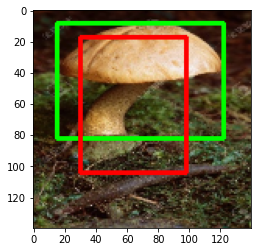

In [31]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
  image,gt_bbox=validset[0] #(c,h,w)
  image=image.unsqueeze(0).to(DEVICE) #(bs,c,h,w)
  out_bbox = model(image)

  utils.compare_plots(image,gt_bbox,out_bbox)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya